## **Recipe Recommendation System**

### **Project Goal**
To develop a recommendation system that suggests recipes to users based on their taste preferences, past ratings, and similar users’ behavior.

In [1]:
#needed libraries
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [2]:
#load the data
recipes = pd.read_csv('recipes.csv')
reviews = pd.read_csv('reviews.csv')

In [3]:
recipes.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


##### **Recipes Dataset Description**

The dataset contains recipes along with nutritional information, author details, and metadata. 

**RecipeId:** Unique identifier for each recipe  
**Name:** Name or title of the recipe  
**AuthorId:** Unique identifier of the recipe’s author  
**AuthorName:** Name of the recipe’s author  
**CookTime:** Cooking time in minutes  
**PrepTime:** Preparation time in minutes  
**TotalTime:** Total time required (prep + cook)  
**DatePublished:** Date the recipe was published  
**Description:** Short textual description of the recipe  
**Images:** URLs or paths to recipe images  
**RecipeCategory:** Category or type of the recipe (e.g., dessert, main course)  
**Keywords:** Keywords associated with the recipe (tags, cuisine, ingredients)  
**RecipeIngredientQuantities:** Quantity of each ingredient used  
**RecipeIngredientParts:** Names of ingredients used  
**AggregatedRating:** Average user rating for the recipe   
**ReviewCount:** Number of reviews for the recipe  
**Calories:** Energy content per serving (kcal)  
**FatContent:** Total fat content per serving (grams)  
**SaturatedFatContent:** Saturated fat content per serving (grams)  
**CholesterolContent:** Cholesterol content per serving (mg)  
**SodiumContent:** Sodium content per serving (mg)  
**CarbohydrateContent:** Carbohydrate content per serving (grams)  
**FiberContent:** Dietary fiber per serving (grams)  
**SugarContent:** Sugar content per serving (grams)  
**ProteinContent:** Protein content per serving (grams)  
**RecipeServings:** Number of servings the recipe yields  
**RecipeYield:** Yield description (e.g., “4 servings”, “1 cake”)  
**RecipeInstructions:** Step-by-step cooking instructions  


In [4]:
#dataset info
recipes.info

<bound method DataFrame.info of         RecipeId                                              Name  \
0             38                 Low-Fat Berry Blue Frozen Dessert   
1             39                                           Biryani   
2             40                                     Best Lemonade   
3             41                    Carina's Tofu-Vegetable Kebabs   
4             42                                      Cabbage Soup   
...          ...                                               ...   
522512    541379                    Meg's Fresh Ginger Gingerbread   
522513    541380  Roast Prime Rib au Poivre with Mixed Peppercorns   
522514    541381                             Kirshwasser Ice Cream   
522515    541382          Quick & Easy Asian Cucumber Salmon Rolls   
522516    541383                           Spicy Baked Scotch Eggs   

          AuthorId      AuthorName CookTime PrepTime TotalTime  \
0             1533          Dancer    PT24H    PT45M  PT24H45

In [5]:
#statistical summary
recipes.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


In [6]:
reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


##### **Reviews Dataset Description**

This dataset contains user reviews and ratings for recipes.

**ReviewId:** Unique identifier for each review  
**RecipeId:** Unique identifier of the recipe being reviewed  
**AuthorId:** Unique identifier of the user who submitted the review  
**AuthorName:** Name of the user who submitted the review  
**Rating:** Rating given by the user (numerical score)  
**Review:** Text content of the user’s review.
**DateSubmitted:** Date the review was submitted  
**DateModified:** Date the review was last modified


In [7]:
#dataset info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


In [8]:
#statistical summary 
reviews.describe()

,ReviewId,RecipeId,AuthorId,Rating
count,1.401982e+06,1.401982e+06,1.401982e+06,1.401982e+06
mean,8.179739e+05,1.526412e+05,1.558638e+08,4.407951e+00
std,5.280821e+05,1.301112e+05,5.305111e+08,1.272012e+00
min,2.000000e+00,3.800000e+01,1.533000e+03,0.000000e+00
25%,3.743862e+05,4.703875e+04,1.336800e+05,4.000000e+00
50%,7.717805e+05,1.093270e+05,3.305450e+05,5.000000e+00
75%,1.204126e+06,2.318768e+05,8.183590e+05,5.000000e+00
max,2.090347e+06,5.412980e+05,2.002902e+09,5.000000e+00


**EDA**

In [9]:
print(f"Total recipes: {recipes.shape[0]}")
print(f"Total reviews: {reviews.shape[0]}")

Total recipes: 522517
Total reviews: 1401982


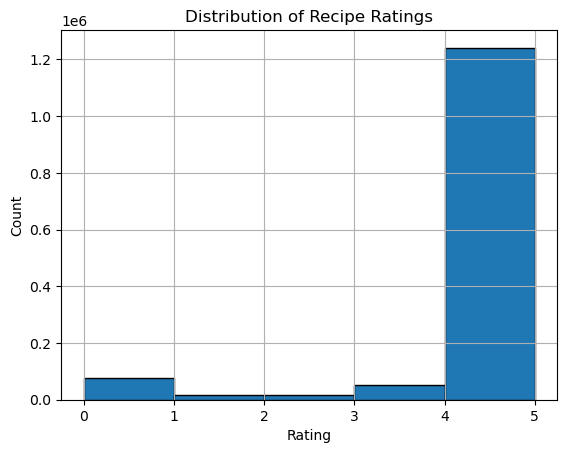

In [10]:
# Distribution of ratings
reviews['Rating'].hist(bins=5, edgecolor='black')
plt.title("Distribution of Recipe Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

From the above, most of the ratings made for the recipes were 5 so meaning the users loved the recipes and that made them give a higher rating.

**Data Preprocessing**

In [11]:
#check for null values
recipes.isna().sum()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

In [12]:
#drop unnecessary columns
to_drop = ['AuthorId','AuthorName','CookTime','PrepTime','TotalTime','DatePublished','Images','RecipeCategory','RecipeIngredientQuantities','AggregatedRating', 'ReviewCount', 'RecipeServings', 'RecipeYield']

recipes = recipes.drop(columns=to_drop)
recipes.head()

,RecipeId,Name,Description,Keywords,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,Make and share this Low-Fat Berry Blue Frozen ...,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,Make and share this Biryani recipe from Food.com.,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,This is from one of my first Good House Keepi...,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,This dish is best prepared a day in advance to...,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,Make and share this Cabbage Soup recipe from F...,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""Mix everything together and bring to a boil..."


In [13]:
#fill the nulls witj an empty string
recipes['Keywords'] = recipes['Keywords'].fillna('')
recipes['Description'] = recipes['Description'].fillna('')


In [14]:
#check for null values
reviews.isna().sum()

ReviewId           0
RecipeId           0
AuthorId           0
AuthorName         0
Rating             0
Review           214
DateSubmitted      0
DateModified       0
dtype: int64

In [15]:
reviews = reviews.drop(columns='Review')
reviews

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
...,...,...,...,...,...,...,...
1401977,2090339,139499,2002080368,terrylbiggs,2,2020-12-27T23:57:54Z,2020-12-27T23:57:54Z
1401978,2090340,148484,41805321,rogerberry,5,2020-12-28T00:44:42Z,2020-12-28T00:44:42Z
1401979,2090341,264191,2002901848,Reiketsukan 6.,5,2020-12-28T01:04:43Z,2020-12-28T01:04:43Z
1401980,2090345,411791,2002901938,Sue M.,5,2020-12-28T03:07:10Z,2020-12-28T03:07:10Z


**Collaborative Filtering**

In [16]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews[['AuthorId','RecipeId','Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD() #matrix factorization
algo.fit(trainset)
predictions = algo.test(testset)

In [17]:
accuracy.rmse(predictions)

RMSE: 1.2274


1.2274319513891863

In [18]:
accuracy.mae(predictions)

MAE:  0.7452


0.7452311461493949

Insight

These metrics indicate the model predicts user ratings with reasonable accuracy. On average, predicted ratings differ from actual ratings by ~0.75 points on the 1–5 scale.


In [19]:

# user
user_id = '2008'

# Get all recipes the user hasn't rated
all_recipes = recipes['RecipeId'].unique()
rated_recipes = reviews[reviews['AuthorId'] == user_id]['RecipeId'].tolist()
unrated_recipes = [r for r in all_recipes if r not in rated_recipes]

# Predict ratings for all unrated recipes using CF model
predictions = [(r, algo.predict(user_id, r).est) for r in unrated_recipes]

# Sort predictions by estimated rating and take Top-N
top_n = 5
top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
top_recipe_ids = [r[0] for r in top_predictions]

#  merge with recipe info 
top_recipes_info = recipes[recipes['RecipeId'].isin(top_recipe_ids)][
    ['RecipeId', 'Name', 'Calories', 'SugarContent', 'ProteinContent','FatContent']
]

print("Top-5 CF Recommended Recipes for User", user_id)
top_recipes_info


Top-5 CF Recommended Recipes for User 2008


,RecipeId,Name,Calories,SugarContent,ProteinContent,FatContent
6558,9545,Sour Cream Chicken Enchiladas,241.6,2.2,5.4,12.4
17678,21033,Toffee Dip with Apples,1192.6,207.7,14.6,21.6
468977,486261,Mexican Stack-Up #RSC,793.0,2.6,43.6,54.1
470340,487669,Just Peachy Grillin' Ribs #RSC,903.2,24.3,66.1,56.4
499895,518151,A.1. Pot Stickers With Chili Pineapple Dipping...,271.3,2.5,16.0,10.2


**Insight**

The collaborative filtering (CF) model predicts a user’s rating for a recipe based on patterns learned from other users with similar tastes. Using matrix factorization (SVD), the model identifies latent factors that capture preferences of both users and recipes, even when the user hasn’t rated a particular recipe.

For example, for User 2008, the CF model analyzes their past ratings alongside the ratings of similar users to recommend recipes they are most likely to enjoy.

**Content Filtering**

In [20]:

# lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Example text columns to combine for CBF
text_cols = ['Description', 'Keywords', 'RecipeIngredientParts']

# Combine text columns 
recipes['text_features'] = recipes[text_cols].fillna('').agg(' '.join, axis=1)

# Preprocessing function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and lemmatize, remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
recipes['text_features_clean'] = recipes['text_features'].apply(clean_text)

In [21]:
#vectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(recipes['text_features_clean'])

In [22]:
# Mapping RecipeId -> row index
recipe_id_to_index = {rid: idx for idx, rid in enumerate(recipes['RecipeId'])}


In [23]:
#get similar recipes
def get_similar_recipes(recipe_id, top_n=5):
    # index the recipe
    idx = recipe_id_to_index[recipe_id]
    
    # cosine similarity with all other recipes
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Get top-N similar indices (excluding the recipe itself)
    similar_indices = cosine_similarities.argsort()[::-1][1:top_n+1]
    
    # Map back to RecipeIds
    similar_ids = recipes.iloc[similar_indices]['RecipeId']
    
    return recipes[recipes['RecipeId'].isin(similar_ids)][['RecipeId', 'Name', 'Calories', 'ProteinContent','SugarContent','FatContent']]


In [24]:

get_similar_recipes(515167, top_n=5)


,RecipeId,Name,Calories,ProteinContent,SugarContent,FatContent
496244,514451,Cheesy Shredded Hash Potato Bacon Ranch Cruste...,456.2,13.4,2.0,42.9
496575,514793,Potato Stuffed Poblano Peppers #SP5,157.4,8.1,0.5,11.6
496802,515023,Potato Artichoke Casserole #SP5,268.5,9.9,3.3,20.5
496889,515110,Brown Sugar and Molasses Red Potatoes #SP5,252.1,2.4,20.6,17.6
496915,515136,Cheesy Home Fry Bake #SP5,768.8,23.8,4.5,73.9


**Insight**

The content-based filtering model recommends recipes based on similarities in ingredients, keywords, and description of the recipes. It computes cosine similarity between a recipe’s feature vector and all other recipes to find the most similar ones, independent of user ratings.

For example, for the recipe Simply Irresistible Tropical Potato Salad, the CBF model identifies other recipes with overlapping ingredients or similar cooking themes, such as potato-based or vegetable-centric dishes. This allows the system to suggest recipes that align closely with the user’s taste, even for new recipes with no prior ratings.

**Hybrid recommendation**

In [25]:
def hybrid_recommendations(user_id, seed_recipe_id, top_n=5, alpha=0.6):
    # collaborative filtering
    all_recipe_ids = recipes['RecipeId'].unique()
    cf_scores={}
    for rid in all_recipe_ids:
        pred = algo.predict(user_id, rid)
        cf_scores[rid] = pred.est

    # content based filtering
    idx = recipe_id_to_index[seed_recipe_id]
    sim_scores = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    cbf_scores = {rid: sim_scores[recipe_id_to_index[rid]] for rid in all_recipe_ids}

    # cobine score
    final_scores = {}
    for rid in all_recipe_ids:
        final_scores[rid] = alpha * cf_scores[rid] + (1 - alpha) * cbf_scores[rid]

    #top N recommentations
    top_rec = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    #recipe details
    top_rec_df = recipes.set_index('RecipeId').loc[[rid for rid, _ in top_rec]].reset_index()
    return top_rec_df


In [26]:
hybrid_recs = hybrid_recommendations(2008, 514451, top_n=5, alpha=0.6)
hybrid_recs[['RecipeId', 'Name', 'Calories', 'ProteinContent','SugarContent','FatContent']]


,RecipeId,Name,Calories,ProteinContent,SugarContent,FatContent
0,514966,Tuscan Brunch Bake #SP5,330.5,11.0,1.0,30.7
1,514967,Parisian Brie Melt #SP5,96.8,4.1,3.2,7.2
2,9497,Chicken and Broccoli Braid,573.9,21.1,7.9,17.2
3,514451,Cheesy Shredded Hash Potato Bacon Ranch Cruste...,456.2,13.4,2.0,42.9
4,278735,Mustard Grilled Chicken (Light),151.8,28.2,1.4,2.1


**Insight**

The hybrid recommendation system combines collaborative filtering and content-based filtering to provide more personalized recipe suggestions. For User 2008 and the recipe Cheesy Shredded Hash Potato Bacon Ranch Crust (ID 514451), the system recommends recipes that the user is likely to enjoy based on similar users’ preferences (CF) and that are similar in ingredients, keywords, and description to the chosen recipe (CBF). By weighting CF and CBF scores (alpha=0.6), the hybrid approach balances taste preferences with recipe content, producing recommendations that are both relevant and diverse.